# **Solução do problema**

-- Objetivo do problema:
    -- Previsão do 1º destino que um novo usuário irá escolher.
    -- Porque?
        -- Qual o tipo de modelo de negócio do Airbnb
            -- Marketplace (Conecta pessoas que oferecem acomodação com pessoas que procuram acomodação)
            -- Oferta (Pessoas oferecendo acomodacao)
                -- Tamanho do portfólio
                -- Diversidade/Densidade de portfólio
            -- Demanda (Pessoas procurando acomodacao)
                -- Número de usuários
                -- LTV (Life Time Value)
                -- CAC (Client Aquisition Cost)
                
    > Gross Revenue = (Preco medio * numero de cliente) - CAC
            
-- Proposta da solucao:
    -- Modelo de previsao do primeiro destino de um usuário
        -- Predicoes e salvar em tabela no banco de dados
        -- API
            -- Input: usuario e caracteristicas
            -- Output: usuarios, caracteristicas e *predicao do destino*

# 0.0 Imports

In [1]:
import pandas as pd
import random
import seaborn as sns


from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt

from keras      import models          as ml
from keras      import layers          as l

2022-12-08 10:51:26.152749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 10:51:26.855008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 10:51:26.855057: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 10:51:30.774575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
df_raw = pd.read_csv('../datasets/train_users_2.csv', low_memory=True)

In [3]:
df_sessions = pd.read_csv('../datasets/sessions.csv', low_memory=True)

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Users:

In [5]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 213451
Número de colunas: 16


### 1.1.1 Data type

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 1.1.2 Check NA

In [11]:
df1.isna().sum() / df1.shape[0]

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [14]:
# porcentagem de quem nao tem booking em cada destino
aux = df1[df1['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

In [15]:
# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

In [19]:
# porcentagem de idades em cada destino
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

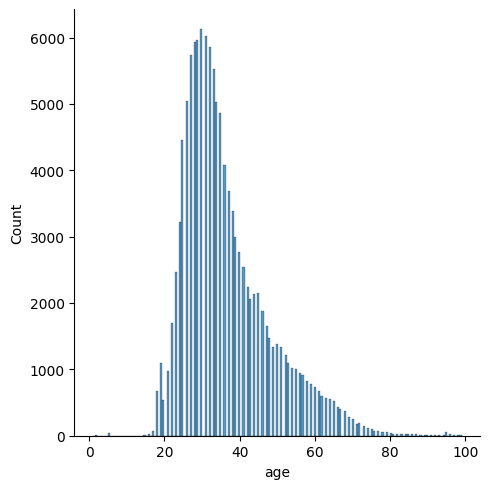

In [25]:
sns.displot(df1[df1['age'] < 100]['age'])

In [28]:
# age
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

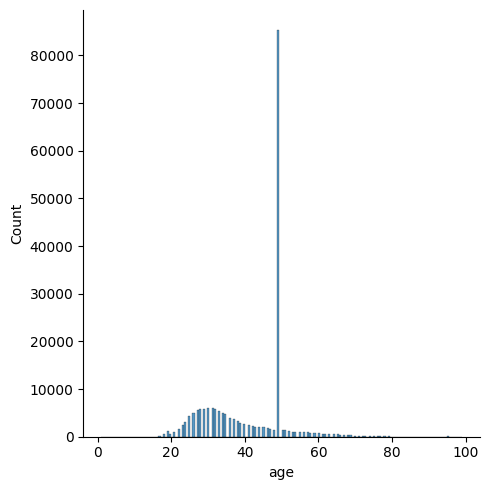

In [36]:
sns.displot(df1[df1['age'] < 100]['age'])

In [31]:
# first_affiliate_tracked
df1 = df1.dropna()

In [32]:
df1.isna().sum()/df1.shape[0]

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [33]:
df1.shape

(207386, 16)

### 1.1.3 Change Data Type

In [34]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])
# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
# age
df1['age'] = df1['age'].astype(int)

### 1.1.3 Check Balanced Data

In [35]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.2 Sessions:

In [12]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [14]:
df_sessions[df_sessions['user_id'] == 'd1mm9tcy42'][['user_id', 'action']].groupby('user_id').count()

,action
user_id,
d1mm9tcy42,126


In [16]:
df_sessions[df_sessions['user_id'] == 'd1mm9tcy42'][['user_id', 'action']].value_counts()

user_id     action                     
d1mm9tcy42  show                           28
            personalize                    25
            lookup                         23
            search_results                 12
            index                          11
            similar_listings                9
            ajax_refresh_subtotal           8
            hosting_social_proof            2
            active                          1
            ask_question                    1
            decision_tree                   1
            faq_experiment_ids              1
            header_userpic                  1
            multi                           1
            other_hosting_reviews_first     1
            recent_reservations             1
dtype: int64

# 2.0 Data Filtering

In [32]:
df2 = df1.copy()

## 2.1 Filtering Rows

## 2.2 Columns Selection

# 3.0 Data Preparation

In [57]:
df3 = df2.copy()

In [59]:
# dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id','country_destination'], axis=1))

# join 'id' and 'country destination'
df3 = pd.concat([df3[['id','country_destination']], df3_dummy], axis=1)

In [61]:
df3.head()

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,lsw9q7uk0j,US,2010-01-02,2010-01-02 01:25:58,2010-01-05,46,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
7,0d01nltbrs,US,2010-01-03,2010-01-03 19:19:05,2010-01-13,47,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


# 4.0 Feature Selection

In [62]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'id']
df4 = df3.drop(cols_drop, axis=1)

In [63]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [64]:
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 5.0 Machine Learning Model

## 5.1 Baseline Model

In [108]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_val.shape[0]
country_destination_wights = df1['country_destination'].value_counts(normalize=True).sort_index() 

yhat_random = random.choices(population=country_destination_list, k=k_num, weights=country_destination_wights)
len(yhat_random)

13635

Accuracy: 0.51998533186652
Balanced Accuracy: 0.09024291228587164
Kappa Score: 0.0003471634637964849
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.02      0.02      0.02       214
          DE       0.01      0.01      0.01       170
          ES       0.03      0.03      0.03       345
          FR       0.05      0.05      0.05       710
          GB       0.01      0.01      0.01       344
          IT       0.03      0.02      0.03       423
          NL       0.02      0.02      0.02       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

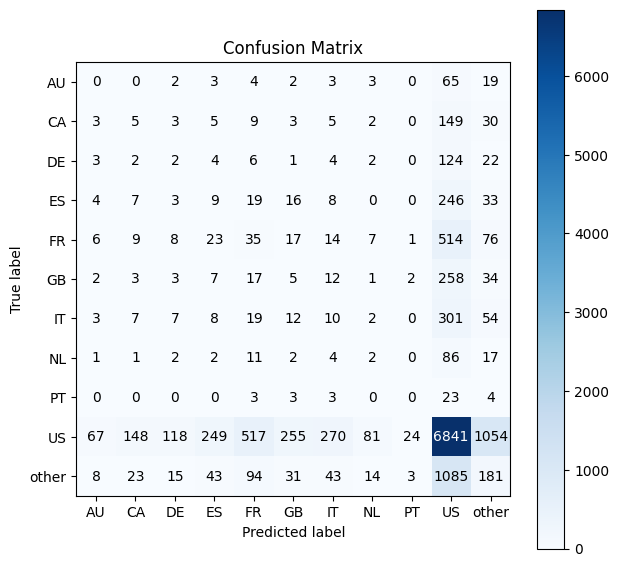

In [109]:
# accuracy
acc_random = m.accuracy_score(y_val, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_val, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_score_random = m.cohen_kappa_score(y_val, yhat_random)
print('Kappa Score: {}'.format(kappa_score_random))

# Classification Report
print(m.classification_report(y_val, yhat_random ))

# Confusion Matrix
mt.plot_confusion_matrix(y_val, yhat_random, normalize=False, figsize=(7,7))

## 5.2 Neural Network (MLP)

In [65]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [67]:
# model definition
model = ml.Sequential()
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model train
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.3400 - accuracy: 0.7056
Epoch 2/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.2808 - accuracy: 0.7072
Epoch 3/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.2504 - accuracy: 0.7080
Epoch 4/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.2234 - accuracy: 0.7081
Epoch 5/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.2042 - accuracy: 0.7084
Epoch 6/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.1893 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1730 - accuracy: 0.7085
Epoch 8/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1646 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.1566 - accuracy: 0.7086
Epoch 10/100
1705/1705 [==============================] - 8s 5ms/step - l

# 6.0 NN Performance

In [86]:
# prediction
pred_nn = model.predict(X_val)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

427/427 [==============================] - 1s 1ms/step


Accuracy: 0.7028969563623029
Balanced Accuracy: 0.09137349898814279
Kappa Score: 0.00029349375776455133
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.33      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.33      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.11      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.13      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

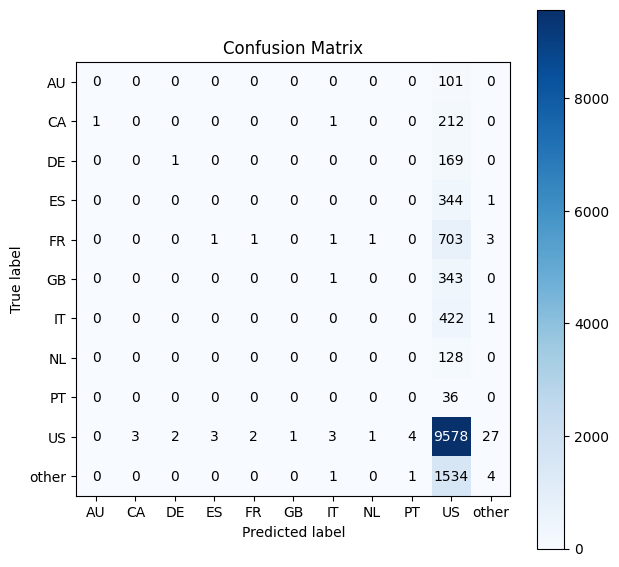

In [99]:
# accuracy
acc_nn = m.accuracy_score(y_val_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_val_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_score_nn = m.cohen_kappa_score(y_val_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_score_nn))

# Classification Report
print(m.classification_report(y_val_nn, yhat_nn ))

# Confusion Matrix
mt.plot_confusion_matrix(y_val_nn, yhat_nn, normalize=False, figsize=(7,7))

# 7.0 Cross-Validation

In [ ]:
# genarate k-fold
n_folds = 5
kfold = ms.StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 0
for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, n_folds))
    # get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))

    # model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # model train
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_fold_nn = model.predict(x_val_fold)
    yhat_fold_nn = ohe.inverse_transform(pred_fold_nn)
    
    # prepare data
    y_val_fold_nn = y_val_fold.to_numpy()
    yhat_cv = yhat_fold_nn.reshape(1,-1)[0]

    # metrics
    ## Balanced Accuracy
    balanced_acc_nn_cv = m.balanced_accuracy_score(y_val_fold_nn, yhat_cv)
    balanced_acc_list.append(balanced_acc_nn_cv)
    
    ## Kappa Metrics
    kappa_acc_nn_cv = m.cohen_kappa_score(y_val_fold_nn, yhat_cv)
    kappa_acc_list.append(kappa_acc_nn_cv)
    
    i += 1

Fold Number: 0/5
341/341 [==============================] - 1s 4ms/step
Fold Number: 1/5
341/341 [==============================] - 1s 3ms/step
Fold Number: 2/5
341/341 [==============================] - 1s 3ms/step
Fold Number: 3/5


In [ ]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.mean(balanced_acc_list), np.std(balanced_acc_list)))
print('Avg Kappa: {} +/- {}'.format(np.mean(kappa_acc_list), np.std(kappa_acc_list)))